In [169]:
import os
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score,f1_score,roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import VGG16, VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from keras.saving import save_model

In [41]:
np.random.seed(42)

## Data Preprocessing ##

Defining path and Image Dimensions

In [42]:
train_dir = 'C:\\Users\\USER\\OneDrive\\Desktop\\Datasets\\DL\\skinCancer - Lab6\\train'
test_dir = 'C:\\Users\\USER\\OneDrive\\Desktop\\Datasets\\DL\\skinCancer - Lab6\\test'

img_width, img_height = 224, 224

Defining the batch size

In [43]:
batch_size = 32

Data Augmentation

In [44]:
train_datagen = ImageDataGenerator(
    rescale=1./255,         
    rotation_range=20,       
    width_shift_range=0.2,   
    height_shift_range=0.2, 
    shear_range=0.2,         
    zoom_range=0.2,          
    horizontal_flip=True,    
    vertical_flip=True,   
    validation_split = 0.2,
    fill_mode='nearest'      
)

Inference: By performing data augmentation the model can understand different patterns from the images as we are doing operations like rotating, scaling, shearing, zooming etc. The model is exposed to different variations of the input data, which helps it generalize better to unseen examples and improves its robustness.

In [45]:
test_datagen = ImageDataGenerator(rescale=1./255)

Defining training generators

In [50]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'  
)

Found 2637 images belonging to 2 classes.


Defining testing generator

In [66]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'  
)


Found 660 images belonging to 2 classes.


Checking class labels for train and test set

In [52]:
print("Class labels for train set:", train_generator.class_indices)
print("Class labels for test set:", test_generator.class_indices)

Class labels for train set: {'benign': 0, 'malignant': 1}
Class labels for test set: {'benign': 0, 'malignant': 1}


## Building VGG19 & CNN Model ##

Defining function for VGG19 Model

In [53]:
def vggModel(input_shape, num_classes):
    
    # Loading pre-trained model 
    
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)  
    
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])

    return model

Defining function for CNN Model

In [54]:
def cnnModel(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'), # relu introduces non linearity
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])

    return model

Defining input shape and number of classes

In [55]:
input_shape = (224, 224, 3)  
num_classes = 1  

Creating VGG19 Model

In [56]:
vgg19_model = vggModel(input_shape, num_classes)

Creating CNN Model

In [57]:
cnn_model = cnnModel(input_shape, num_classes)

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model Summary

In [58]:
vgg19_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ ?                           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [59]:
cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,526,465 (74.49 MB)

 Trainable params: 19,526,465 (74.49 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
optimizer = optimizers.Adam(learning_rate=0.001)

Compiling VGG19 Model

In [61]:
vgg19_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

Compiling CNN Model

In [74]:
cnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

Defining early stopping callback

In [63]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Training  VGG19 Model

In [67]:
buildVgg19 = vgg19_model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10


C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 2681s 32s/step - accuracy: 0.5691 - loss: 1.8062 - val_accuracy: 0.8061 - val_loss: 0.4518
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1833s 22s/step - accuracy: 0.7234 - loss: 0.5330 - val_accuracy: 0.8258 - val_loss: 0.4197
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1032s 12s/step - accuracy: 0.7269 - loss: 0.5328 - val_accuracy: 0.8258 - val_loss: 0.4399
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1170s 14s/step - accuracy: 0.6731 - loss: 0.5567 - val_accuracy: 0.6924 - val_loss: 0.5682
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1059s 13s/step - accuracy: 0.7181 - loss: 0.5355 - val_accuracy: 0.8167 - val_loss: 0.3773
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2327s 28s/step - accuracy: 0.7293 - loss: 0.5508 - val_accuracy: 0.8303 - val_loss: 0.3864
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1707s 20s/step - accuracy: 0.6984 - loss: 0.5378 - val_accuracy: 0.7030 - val_loss: 0.4833
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 1030s 12s/step - accuracy: 0.6951 - loss: 0.5531 - val_accuracy: 0.834

Inference: Model's training and validation performance improved initially as we can observe the increase in accuracy and decrease in loss. After the 4th epoch the loss started to increase indicating the model may have started to overfit the training data. 

I used EarlyStopping callback, it monitors a specified metric (val_loss) and it stops the training if the metric does not improve for a certain number of epochs. This is the common technique used to prevent overfitting and to ensure that the model is not trained for too many epochs, which could lead to decrease performance on unseen data. So the model stopped training at 8th epoch.

Training CNN Model

In [77]:
buildCNN = cnn_model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = 10,
    # callbacks = [early_stopping]
)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.7705 - loss: 0.4818 - val_accuracy: 0.7439 - val_loss: 0.4641
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 340s 4s/step - accuracy: 0.7755 - loss: 0.4322 - val_accuracy: 0.7864 - val_loss: 0.3954
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 347s 4s/step - accuracy: 0.7726 - loss: 0.4527 - val_accuracy: 0.7924 - val_loss: 0.3910
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 330s 4s/step - accuracy: 0.7931 - loss: 0.4363 - val_accuracy: 0.7894 - val_loss: 0.4211
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 338s 4s/step - accuracy: 0.7620 - loss: 0.4659 - val_accuracy: 0.7818 - val_loss: 0.4124
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 335s 4s/step - accuracy: 0.7734 - loss: 0.4268 - val_accuracy: 0.8076 - val_loss: 0.4355
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 333s 4s/step - accuracy: 0.8172 - loss: 0.4103 - val_accuracy: 0.7970 - val_loss: 0.3868
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 547s 7s/step - accuracy: 0.8054 - loss: 0.4255 - val_accuracy: 0.8348 - v

Inference: Model achieves a validation accuracy of 75-80% which is reasonable for many classification tasks. The validation loss stabilizes around a certain value. It shows a decent performance.

In [81]:
vgg19_test_loss, vgg19_test_acc = vgg19_model.evaluate(test_generator)
custom_cnn_test_loss, custom_cnn_test_acc = cnn_model.evaluate(test_generator)

print("VGG19 Test Loss:", vgg19_test_loss)
print("VGG19 Test Accuracy:", vgg19_test_acc)
print("\nCustom CNN Test Loss:", custom_cnn_test_loss)
print("Custom CNN Test Accuracy:", custom_cnn_test_acc)

21/21 ━━━━━━━━━━━━━━━━━━━━ 523s 25s/step - accuracy: 0.8263 - loss: 0.3627
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 944ms/step - accuracy: 0.7288 - loss: 0.4439
VGG19 Test Loss: 0.376758337020874
VGG19 Test Accuracy: 0.8166666626930237

Custom CNN Test Loss: 0.4166063964366913
Custom CNN Test Accuracy: 0.7545454502105713


Inference: VGG19 model appears to be outperform CNN model in terms of both test loss and accuracy on testing data.

Evaluations of both the model based on metrics

In [82]:
vgg19_predictions = vgg19_model.predict(test_generator)
vgg19_predicted_labels = (vgg19_predictions > 0.5).astype(int) 

21/21 ━━━━━━━━━━━━━━━━━━━━ 175s 8s/step


In [83]:
vgg19_accuracy = accuracy_score(test_generator.labels, vgg19_predicted_labels)
vgg19_precision = precision_score(test_generator.labels, vgg19_predicted_labels)
vgg19_recall = recall_score(test_generator.labels, vgg19_predicted_labels)
vgg19_f1 = f1_score(test_generator.labels, vgg19_predicted_labels)

In [84]:
print("Metrics for VGG19 Model:")
print("Accuracy:", vgg19_accuracy)
print("Precision:", vgg19_precision)
print("Recall:", vgg19_recall)
print("F1-score:", vgg19_f1)
print()

Metrics for VGG19 Model:
Accuracy: 0.4863636363636364
Precision: 0.44108761329305135
Recall: 0.4866666666666667
F1-score: 0.46275752773375595



In [86]:
custom_cnn_predictions = cnn_model.predict(test_generator)
custom_cnn_predicted_labels = (custom_cnn_predictions > 0.5).astype(int) 

21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 310ms/step


In [87]:
custom_cnn_accuracy = accuracy_score(test_generator.labels, custom_cnn_predicted_labels)
custom_cnn_precision = precision_score(test_generator.labels, custom_cnn_predicted_labels)
custom_cnn_recall = recall_score(test_generator.labels, custom_cnn_predicted_labels)
custom_cnn_f1 = f1_score(test_generator.labels, custom_cnn_predicted_labels)

In [88]:
print("Metrics for Custom CNN Model:")
print("Accuracy:", custom_cnn_accuracy)
print("Precision:", custom_cnn_precision)
print("Recall:", custom_cnn_recall)
print("F1-score:", custom_cnn_f1)

Metrics for Custom CNN Model:
Accuracy: 0.48787878787878786
Precision: 0.45869565217391306
Recall: 0.7033333333333334
F1-score: 0.5552631578947368


Inference: Based on the metrics CNN model appears to perform better than VGG19 model as it achieves higher precision, recall, f1 score etc.

Visualizing training loss for both the architectures

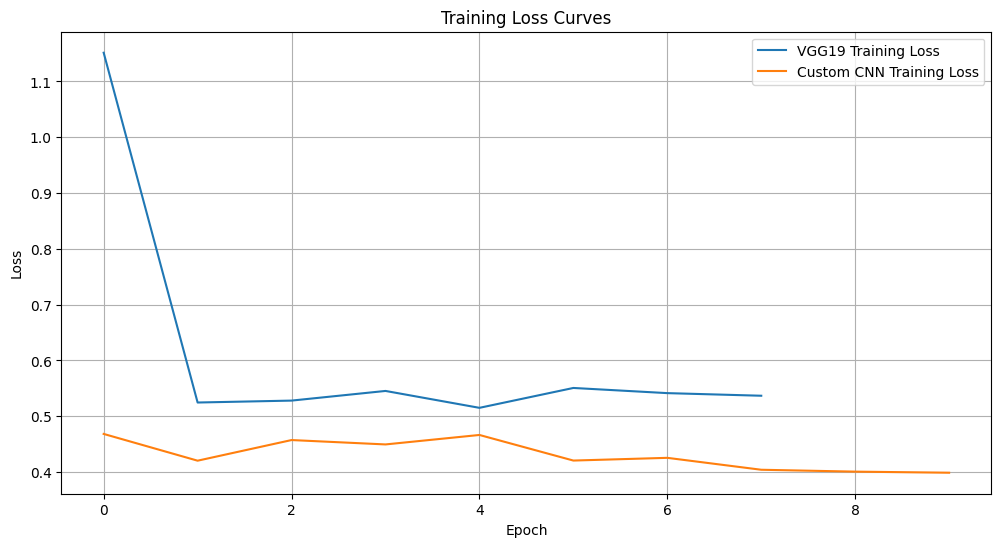

In [92]:
plt.figure(figsize=(12, 6))
plt.plot(buildVgg19.history['loss'], label='VGG19 Training Loss')
plt.plot(buildCNN.history['loss'], label='Custom CNN Training Loss')
plt.title('Training Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Inference: We can observe that the training loss for both the architecture is decreasing gradually

Visualizing training accuracy for both the architectures

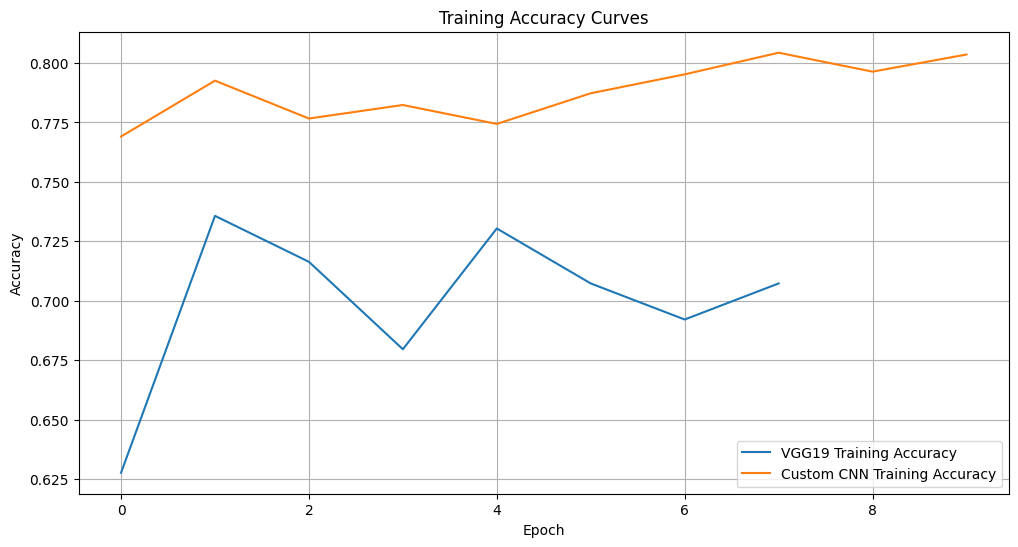

In [94]:
plt.figure(figsize=(12, 6))
plt.plot(buildVgg19.history['accuracy'], label='VGG19 Training Accuracy')
plt.plot(buildCNN.history['accuracy'], label='Custom CNN Training Accuracy')
plt.title('Training Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Inference: Here we can observe that the training accuracy is gradually increasing for both the models

Visualing ROC Curves and Confusion Matrix

In [98]:
test_labels = test_generator.classes

In [99]:
fpr_vgg19, tpr_vgg19, _ = roc_curve(test_labels, vgg19_predictions)
fpr_custom_cnn, tpr_custom_cnn, _ = roc_curve(test_labels, custom_cnn_predictions)

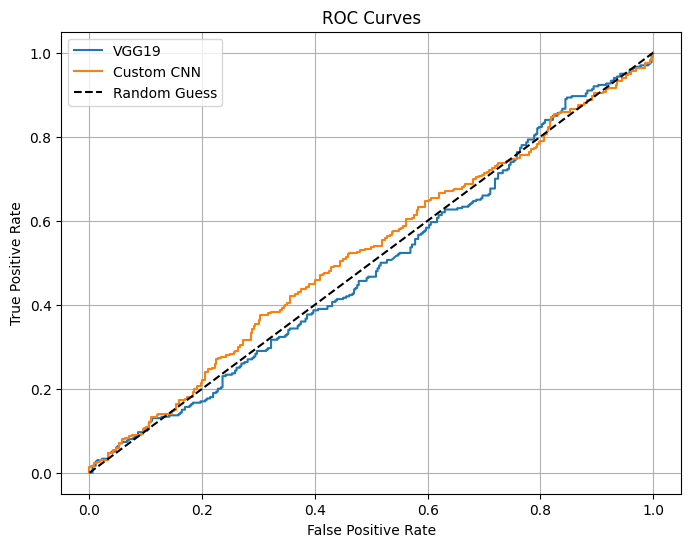

In [100]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_vgg19, tpr_vgg19, label='VGG19')
plt.plot(fpr_custom_cnn, tpr_custom_cnn, label='Custom CNN')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

Inference: There is a room for improvement for both the models. It indicates poor discrimination capabilities. 

In [101]:
vgg19_cm = confusion_matrix(test_labels, (vgg19_predictions > 0.5).astype(int))
custom_cnn_cm = confusion_matrix(test_labels, (custom_cnn_predictions > 0.5).astype(int))

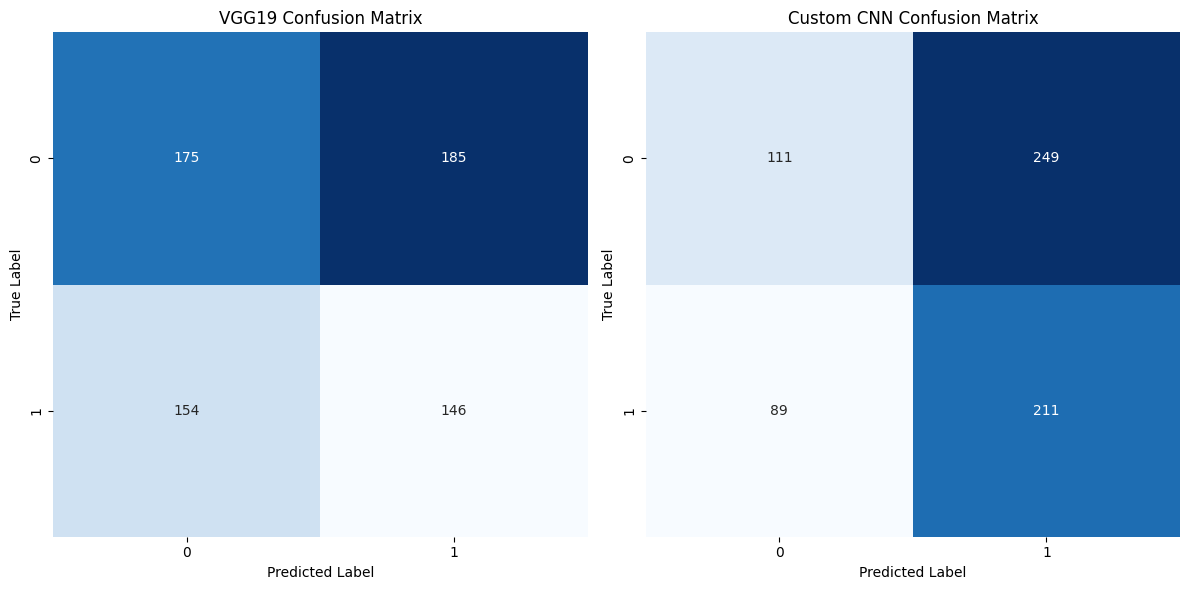

In [102]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(vgg19_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('VGG19 Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.subplot(1, 2, 2)
sns.heatmap(custom_cnn_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Custom CNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [112]:
cnn_model.save('custom_cnn_model.h5')

## Let's try to predict with CNN Model ##

In [144]:
custom_cnn_model = load_model('custom_cnn_model.h5')

In [152]:
imgpath = "C:\\Users\\USER\\OneDrive\\Desktop\\58.jpg"

In [153]:
random_image_path = (imgpath)
img = image.load_img(random_image_path, target_size=(224, 224)) 

In [154]:
img_custom_cnn = image.img_to_array(img) / 255.0  
img_custom_cnn = np.expand_dims(img_custom_cnn, axis=0)

In [155]:
prediction_custom_cnn = custom_cnn_model.predict(img_custom_cnn)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


In [156]:
if prediction_custom_cnn > 0.5:
    print("Custom CNN Prediction: Malignant")
else:
    print("Custom CNN Prediction: Benign")

Custom CNN Prediction: Benign


Inference: The CNN model correctly classified the given image as benign.

# Conclusion #

Both the architectures are having their advantages. VGG19 model performed well on unseen data, the training accuracy and loss is good in CNN model architecture. VGG19 has a millions of paramaters, it has the capability to identify complex patterns. At last we did a prediction using CNN architecture, the model correcty predicted the given benign image as benign. Thus the given task to perform the comparison between CNN and VGG19/16 architures has been implememted successfully.